In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os

### Load Dataset

In [2]:
# This Code Come From Previous
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class']], label['bbox']

train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
data_samples = test.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


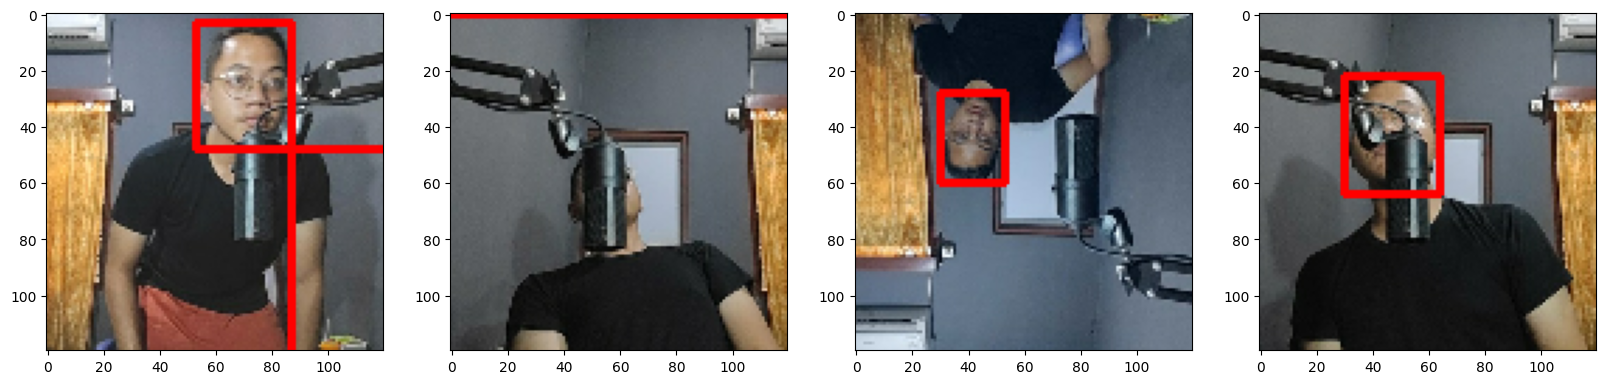

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coordinate = res[1][1][idx]

    cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coordinate[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coordinate[2:], [120,120]).astype(int)), (255,0,0), 2)
    ax[idx].imshow(sample_image)

### Model Building

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### Download Pre-trained model VGG16

In [71]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [72]:
vgg.layers

There are Three model i've made, choose one

In [ ]:
# Without Weight Model
def build_model():
    vgg16 = VGG16(include_top=False)

    input_layer = Input(shape=(120,120,3))

    vgg = vgg16(input_layer)


    f1 = GlobalMaxPooling2D()(vgg)
    class1= Dense(2048, activation='relu')(f1)
    class2= Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2= Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [73]:
# With Imagenet Untrainable Model
def build_model():
    vgg16 = VGG16(weights='imagenet', include_top=False)
    for layer in vgg16.outputs:
        layer.trainable = False

    input_layer = Input(shape=(120,120,3))

    vgg = vgg16(input_layer)


    f1 = GlobalMaxPooling2D()(vgg)
    class1= Dense(2048, activation='relu')(f1)
    class2= Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2= Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [ ]:
# With Imagenet Trainable Model
def build_model():
    vgg16 = VGG16(weights='imagenet', include_top=False)

    input_layer = Input(shape=(120,120,3))

    vgg = vgg16(input_layer)


    f1 = GlobalMaxPooling2D()(vgg)
    class1= Dense(2048, activation='relu')(f1)
    class2= Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2= Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [74]:
facetracker = build_model()

In [75]:
facetracker.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_14[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [76]:
X, y = train.as_numpy_iterator().next()

In [77]:
X.shape

(8, 120, 120, 3)

In [50]:
facetracker.predict(X)

1/1 [==============================] - 0s 256ms/step


[array([[0.332702  ],
        [0.24124435],
        [0.29746762],
        [0.3861077 ],
        [0.36365607],
        [0.29258376],
        [0.35582435],
        [0.34158188]], dtype=float32),
 array([[0.6543644 , 0.5840631 , 0.40149736, 0.29505077],
        [0.62085456, 0.6050361 , 0.39927888, 0.39667454],
        [0.6401408 , 0.5013799 , 0.44574544, 0.31861088],
        [0.6371306 , 0.5626296 , 0.42524296, 0.20074104],
        [0.5461363 , 0.636417  , 0.41334057, 0.24582687],
        [0.592274  , 0.5371794 , 0.41838786, 0.32347143],
        [0.6084667 , 0.44656178, 0.41794428, 0.35475156],
        [0.58502555, 0.5891963 , 0.43040803, 0.24320813]], dtype=float32)]

In [78]:
facetracker.predict(X)

1/1 [==============================] - 0s 286ms/step


[array([[0.7467712 ],
        [0.7158103 ],
        [0.76086974],
        [0.7940617 ],
        [0.7225605 ],
        [0.7540079 ],
        [0.8006982 ],
        [0.69256747]], dtype=float32),
 array([[0.35737413, 0.64354175, 0.70699584, 0.4496072 ],
        [0.3696368 , 0.6659986 , 0.7449192 , 0.4476774 ],
        [0.35087615, 0.6318928 , 0.75762135, 0.60166687],
        [0.3235022 , 0.678053  , 0.7093622 , 0.51262015],
        [0.3357729 , 0.6678256 , 0.7184458 , 0.49506527],
        [0.29552168, 0.6364709 , 0.73428804, 0.5026139 ],
        [0.36167315, 0.6606955 , 0.7186357 , 0.5390688 ],
        [0.33184054, 0.6701241 , 0.7523227 , 0.41344824]], dtype=float32)]

### Defining Losses and Optimizer

In [79]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [80]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [81]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [82]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [83]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 28ms/step


In [84]:
localization_loss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=5.2569327>

### Train Neural Network

In [85]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [86]:
model = FaceTracker(facetracker)


In [87]:
model.compile(opt, classloss, regressloss)


#### Train

In [88]:
logdir='logs3'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


398/398 [==============================] - 52s 110ms/step - total_loss: 0.4159 - class_loss: 0.1397 - regress_loss: 0.3461 - val_total_loss: 0.4892 - val_class_loss: 0.5373 - val_regress_loss: 0.2206
Epoch 2/10
398/398 [==============================] - 50s 109ms/step - total_loss: 0.0374 - class_loss: 0.0069 - regress_loss: 0.0339 - val_total_loss: 4.7082 - val_class_loss: 3.1964 - val_regress_loss: 3.1100
Epoch 3/10
398/398 [==============================] - 49s 109ms/step - total_loss: 0.0265 - class_loss: 0.0046 - regress_loss: 0.0242 - val_total_loss: 1.5450 - val_class_loss: 1.2330 - val_regress_loss: 0.9285
Epoch 4/10
398/398 [==============================] - 49s 109ms/step - total_loss: 0.0186 - class_loss: 0.0053 - regress_loss: 0.0160 - val_total_loss: 0.7629 - val_class_loss: 0.6399 - val_regress_loss: 0.4429
Epoch 5/10
398/398 [==============================] - 58s 129ms/step - total_loss: 0.0080 - class_loss: 4.2607e-04 - regress_loss: 0.0078 - val_total_loss: 3.5319 - va

### Plot The Performance

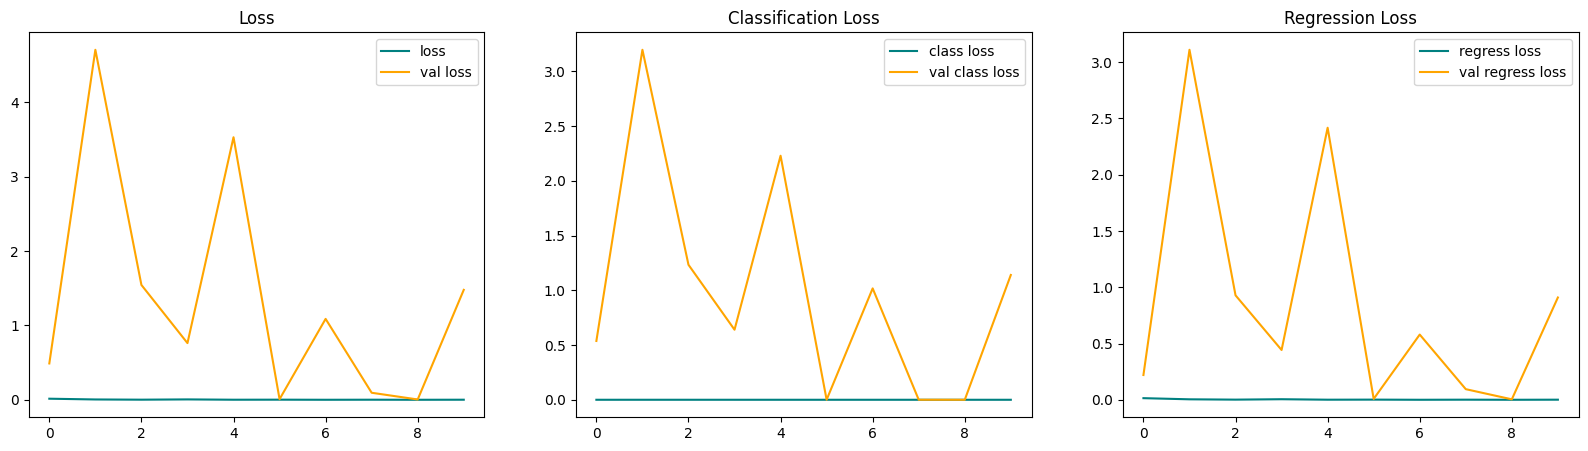

In [89]:
hist.history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Test

In [90]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


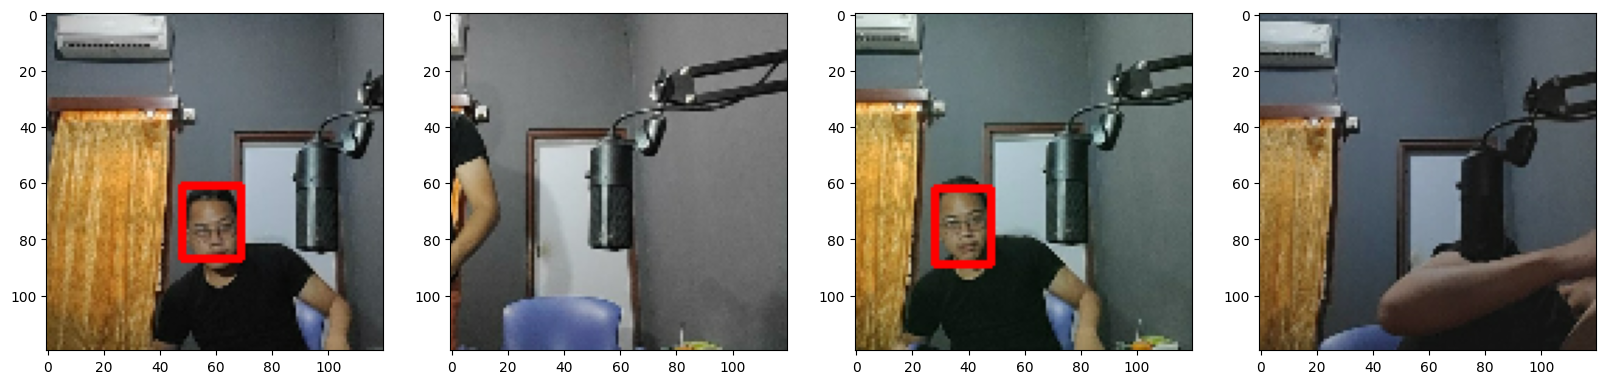

In [91]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Save the Model

In [92]:
facetracker.save('facetracker_imagenet_untrainable.h5')